In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import glob
import math
import os
from typing import Any, Dict, List, Optional, Tuple, Union

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
import requests
from matplotlib.ticker import FuncFormatter
from tqdm.notebook import tqdm

from huhuha.settings import RAW_DATA_DIR, DATA_DIR, RESULTS_DIR
tqdm.pandas()

sns.set_theme(context='poster', style="whitegrid")

In [2]:
def load_df(filepath: str) -> pd.DataFrame:
    file_name = os.path.basename(filepath)
    model_name, sources, zoom_and_runs_num = tuple(file_name.split('__'))
    sources = sources.split('_src_')[1]
    sources = sources.replace('_', ', ')
    zoom_info, _ = tuple(zoom_and_runs_num.split('_num_runs_'))
    zoom_info = zoom_info.split('_zoom_f')[1]
    
    if len(zoom_info.split('_')) > 1:
        double_zoom = True
    else:
        double_zoom = False
        
    zoom_info = zoom_info.replace('_', ', ')
        
        
    df = pd.read_csv(filepath)
    df = df.drop(df.columns[0], axis=1)
    df['model'] = model_name
    df['sources'] = sources
    df['zoom'] = zoom_info
    df['sources_and_model'] = sources + ' - ' + model_name
    df['double_zoom'] = double_zoom
        
    cols = df.columns.tolist()
    cols = cols[-5:] + cols[:-5]
    df = df[cols]
    return df

In [61]:
def visualize_boxplot(
        df: pd.DataFrame,
        measures_to_plot: Union[str, List[str]] = ['test_accuracy', 'test_macro_f1', 'test_f1_0', 'test_f1_1'],
        measures_names: Union[str, List[str]] = ['Accuracy', 'Macro F1', 'F1 - non-avalanche', 'F1 - avalanche'],
        legend_labels: Optional[List[str]] = None,
        suptitle: str = '',
        figsize: Optional[Tuple[float, float]] = None,
        bbox_to_anchor=(1.02, 0.95),
        legend_loc=2,
        legend_cols=1,
        zoom=False,
        **kwargs
    ):  
    
    if isinstance(measures_to_plot, str):
        measures_to_plot = [measures_to_plot]
    if isinstance(measures_names, str):
        measures_names = [measures_names]

    assert len(measures_to_plot) == len(measures_names)
    
    plot_rows = len(measures_to_plot)
    
    if figsize is None:
        figsize = (16, 6*plot_rows)
    
    fig, axis = plt.subplots(plot_rows, 1, figsize=figsize, constrained_layout=True)
    if plot_rows > 1:
        axis =axis.flatten()
    else:
        axis = [axis]
        
    for i, (measure, name) in enumerate(zip(measures_to_plot, measures_names)):        
        ax = axis[i]       
#         sns.pointplot(x='train_size', y=measure, hue='transformer_model_extra_tokens', hue_order=order, 
#                       dodge=0.5, linestyles='--', capsize=0.05, err_style="bars", ci='sd', ax=ax, data=df)   
        sns.boxplot(x='zoom', y=measure, ax=ax, data=df, **kwargs)

        ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
        # ax.set_ylim(bottom=round(df[measures_to_plot].min().min()-0.01, 2),
        #              top=round(df[measures_to_plot].max().max()+0.01, 2))
        ax.set_xlabel('Zoom level')
        ax.set_title(name)
        ax.set_ylabel('Value')
        if zoom:
            ax.set(ylim=(0.78, 0.88))
        else:
            ax.set(ylim=(0.70, 0.88))
    
        handles, labels = ax.get_legend_handles_labels()
        if legend_labels is not None:
            labels = legend_labels
        if len(handles) > 0:
            legend_title = hue.replace('_', ' ').capitalize()           
            ax.legend(handles, labels, title=legend_title, fontsize=18, title_fontsize=22, 
                      bbox_to_anchor=bbox_to_anchor, loc=legend_loc, ncol=legend_cols,
                      borderaxespad=0., fancybox=True)
                    
    fig.suptitle(suptitle)
    
# file_name = suptitle.replace(':', '').replace(' ','-') + '_paper'
# fig.savefig(file_name + '.eps', bbox_inches='tight')
# fig.savefig(file_name + '.pdf', bbox_inches='tight')

In [62]:
result_files = [os.path.join(RESULTS_DIR, f) for f in os.listdir(RESULTS_DIR) if 
                os.path.isfile(os.path.join(RESULTS_DIR, f)) and f.endswith('.csv')]

In [63]:
df_list = list()
for file in result_files[:]:
    df = load_df(file)
    df_list.append(df)

In [64]:
df = pd.concat(df_list)

In [65]:
df.columns

Index(['model', 'sources', 'zoom', 'sources_and_model', 'double_zoom',
       'test_loss', 'test_accuracy', 'test_macro_f1', 'test_precision_0',
       'test_precision_1', 'test_recall_0', 'test_recall_1', 'test_f1_0',
       'test_f1_1'],
      dtype='object')

In [66]:
df.value_counts(['model', 'sources'], sort=False)

model        sources            
CNN_AUG_MLP  arcgis                 20
             arcgis, opentopomap    55
             opentopomap            20
CNN_SEP_MLP  arcgis                 20
             arcgis, opentopomap    45
             opentopomap            20
MLP          arcgis                 20
             arcgis, opentopomap    55
             opentopomap            20
dtype: int64

In [67]:
df.value_counts(['model', 'sources', 'zoom'], sort=False)

model        sources              zoom  
CNN_AUG_MLP  arcgis               12        5
                                  13        5
                                  14        5
                                  15        5
             arcgis, opentopomap  12        5
                                  12, 13    5
                                  12, 14    5
                                  12, 15    5
                                  13        5
                                  13, 14    5
                                  13, 15    5
                                  14        5
                                  14, 15    5
                                  15        5
                                  15, 12    5
             opentopomap          12        5
                                  13        5
                                  14        5
                                  15        5
CNN_SEP_MLP  arcgis               12        5
                                  13   

## Wszystkie architektury modeli -- _accuracy_

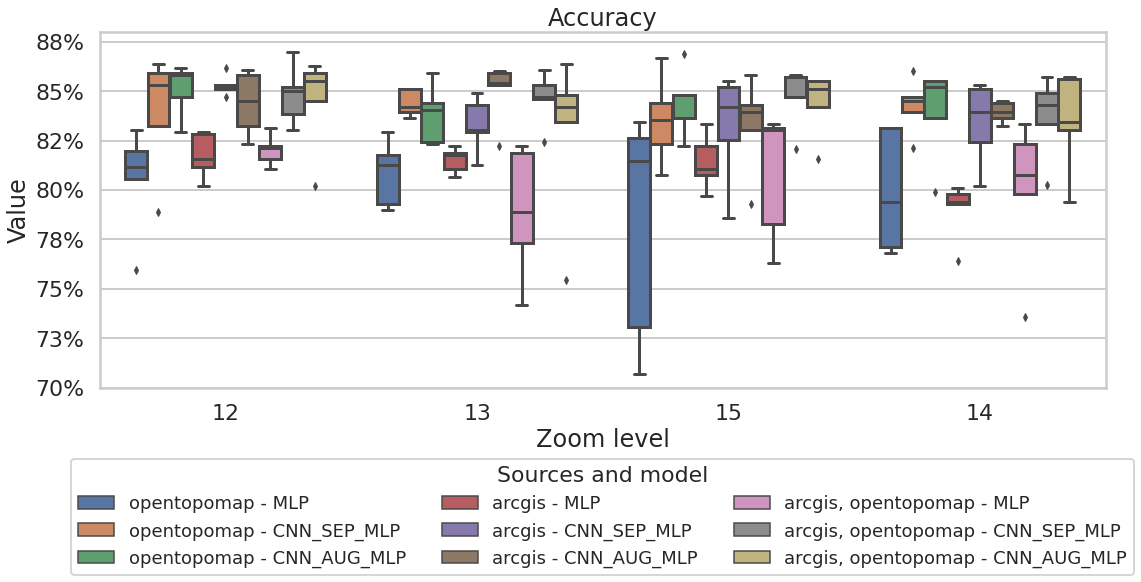

In [68]:
hue_order = [
    'opentopomap - MLP', 'opentopomap - CNN_SEP_MLP', 'opentopomap - CNN_AUG_MLP',
    'arcgis - MLP', 'arcgis - CNN_SEP_MLP', 'arcgis - CNN_AUG_MLP',
    'arcgis, opentopomap - MLP', 'arcgis, opentopomap - CNN_SEP_MLP', 'arcgis, opentopomap - CNN_AUG_MLP'
]
hue= 'sources_and_model'
measures_to_plot = 'test_accuracy'
measures_names = 'Accuracy'

legend_loc = 'upper center'
bbox_to_anchor = (0.5, -0.2)
legend_cols = 3
figsize = (16, 8)

visualize_boxplot(df[df['double_zoom'] == False], measures_to_plot=measures_to_plot, measures_names=measures_names,
                  figsize=figsize, hue=hue, hue_order=hue_order, 
                  legend_loc=legend_loc, bbox_to_anchor=bbox_to_anchor, legend_cols=legend_cols)

Model MLP wypada zawsze zdecydowanie gorzej, nie będzie uwzględniany w dlaszych analizach.

## Wykresy miar F1

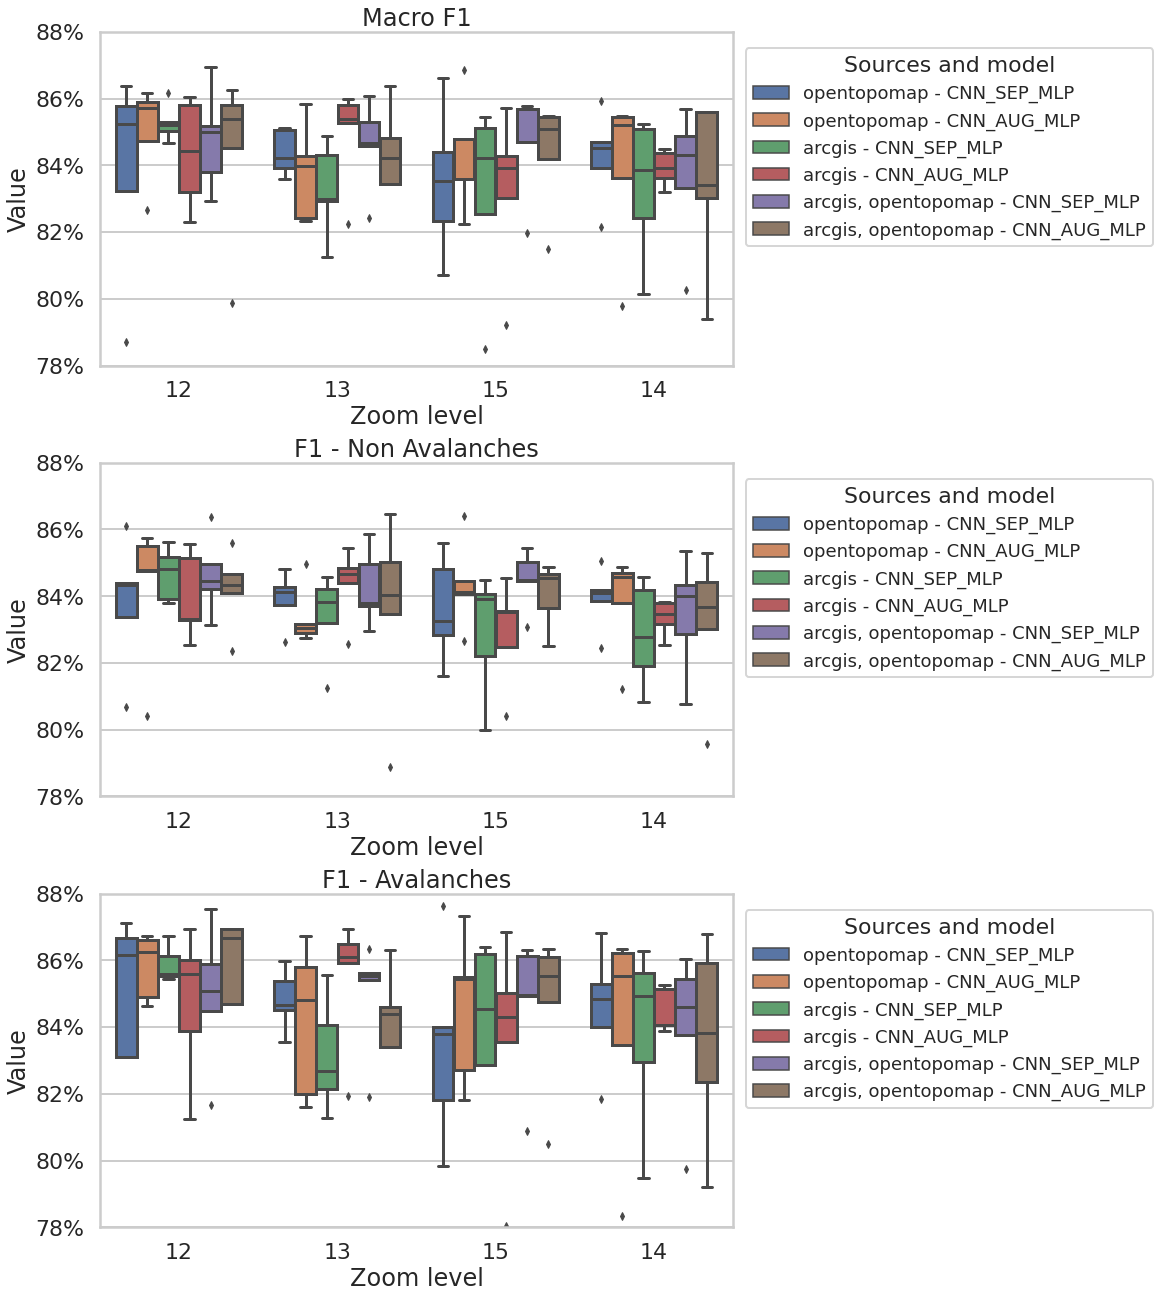

In [69]:
df_to_plot = df[(df['double_zoom'] == False) & (df['model'] != 'MLP')]

hue_order = [
    'opentopomap - CNN_SEP_MLP', 'opentopomap - CNN_AUG_MLP',
    'arcgis - CNN_SEP_MLP', 'arcgis - CNN_AUG_MLP',
    'arcgis, opentopomap - CNN_SEP_MLP', 'arcgis, opentopomap - CNN_AUG_MLP'
]
hue= 'sources_and_model'
measures_to_plot = ['test_macro_f1', 'test_f1_0', 'test_f1_1']
measures_names = ['Macro F1', 'F1 - Non Avalanches', 'F1 - Avalanches']

legend_loc = 'upper center'
bbox_to_anchor = (0.5, -0.2)
legend_cols = 3
figsize = (16, 8)

visualize_boxplot(df_to_plot, measures_to_plot=measures_to_plot, measures_names=measures_names,
                  hue=hue, hue_order=hue_order, zoom=True)

### Bez outlier'ów

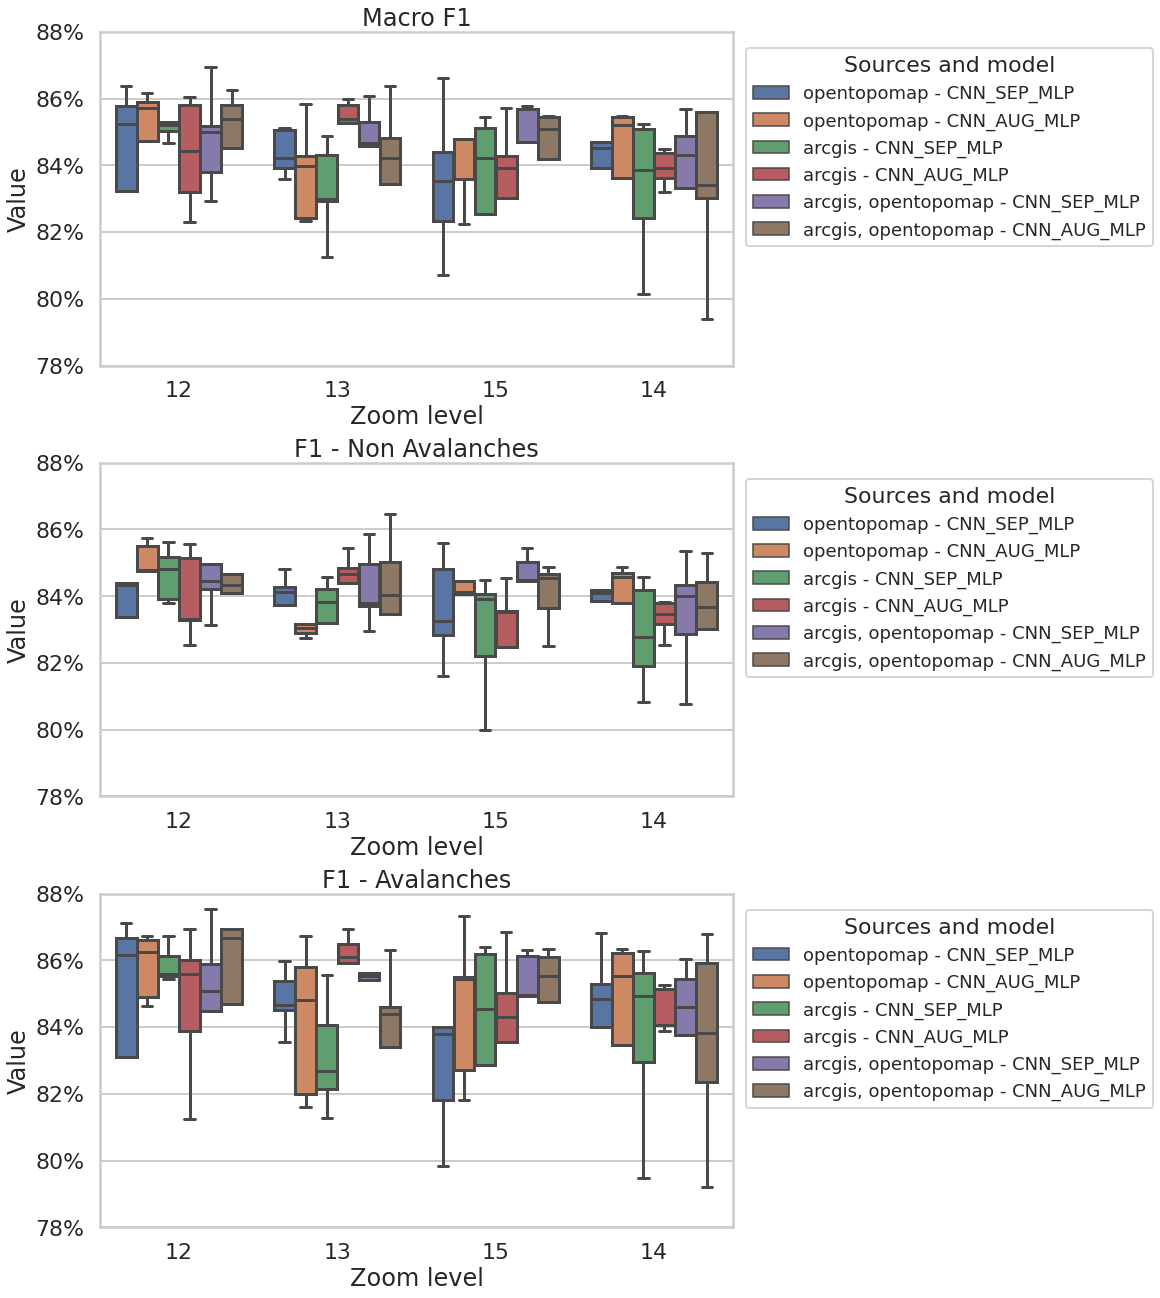

In [70]:
visualize_boxplot(df_to_plot, measures_to_plot=measures_to_plot, measures_names=measures_names,
                  hue=hue, hue_order=hue_order, showfliers=False, zoom=True)

Najlepsze wykrywanie lawin dla _zoom_ równego 13 dla mapy arcgis.

## Wykresy dla dwóch poziomów na raz

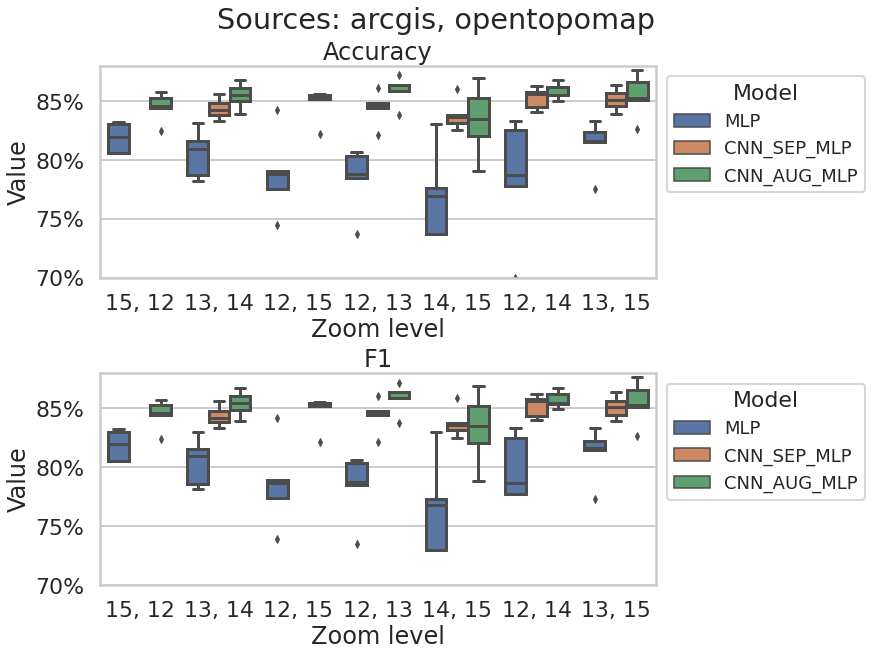

In [72]:
df_to_plot = df[(df['double_zoom'] == True)]

hue_order = [
    'MLP', 'CNN_SEP_MLP', 'CNN_AUG_MLP'
]
hue= 'model'
measures_to_plot = ['test_accuracy', 'test_macro_f1']
measures_names = ['Accuracy', 'F1']

figsize = (12, 9)
suptitle = 'Sources: arcgis, opentopomap'

visualize_boxplot(df_to_plot, measures_to_plot=measures_to_plot, measures_names=measures_names,
                  figsize=figsize, hue=hue, hue_order=hue_order, suptitle=suptitle)

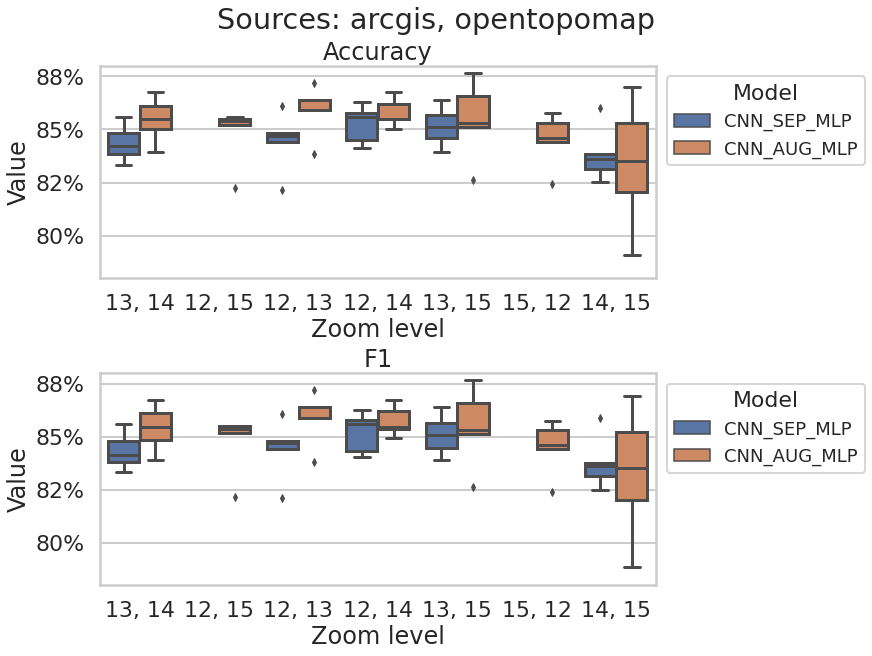

In [73]:
df_to_plot = df[(df['double_zoom'] == True) & (df['model'] != 'MLP')]

hue_order = [
    'CNN_SEP_MLP', 'CNN_AUG_MLP'
]
hue= 'model'
measures_to_plot = ['test_accuracy', 'test_macro_f1']
measures_names = ['Accuracy', 'F1']

figsize = (12, 9)
suptitle = 'Sources: arcgis, opentopomap'

visualize_boxplot(df_to_plot, measures_to_plot=measures_to_plot, measures_names=measures_names,
                  figsize=figsize, hue=hue, hue_order=hue_order, suptitle=suptitle, zoom=True)

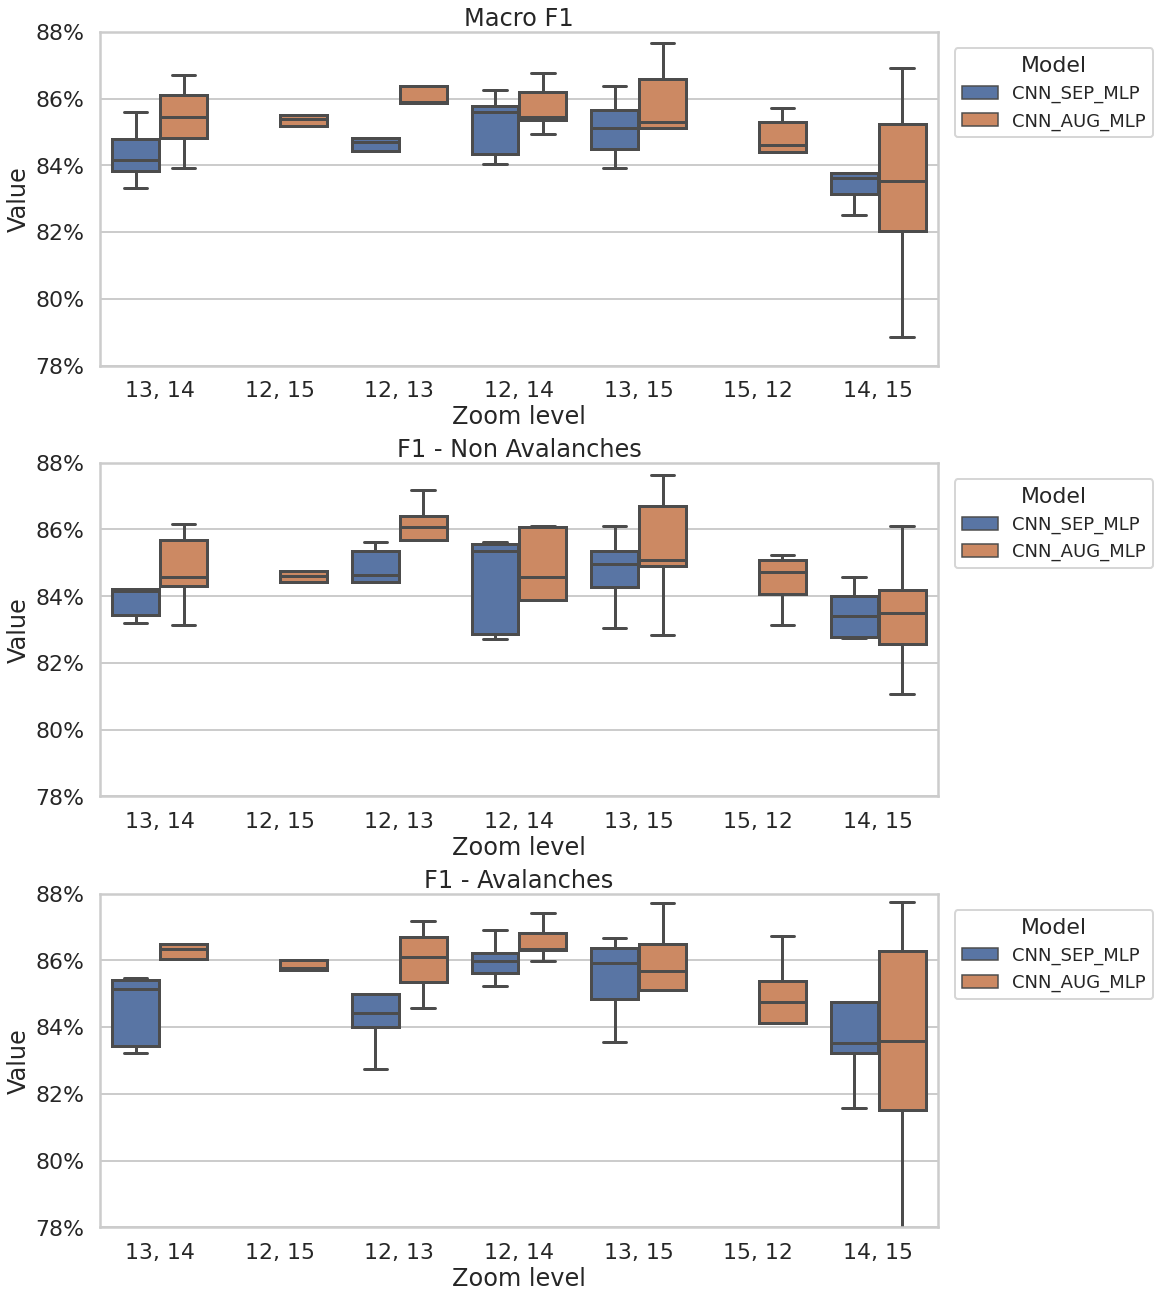

In [75]:
measures_to_plot = ['test_macro_f1', 'test_f1_0', 'test_f1_1']
measures_names = ['Macro F1', 'F1 - Non Avalanches', 'F1 - Avalanches']

visualize_boxplot(df_to_plot, measures_to_plot=measures_to_plot, measures_names=measures_names,
                  hue=hue, hue_order=hue_order, showfliers=False, zoom=True)

Wynikia dla dwóch poziomów lepsze niż dla pojedynczcyh, wartości F1 wyższe a wariancja mniejsza. 

## Wziualizacja na mapie

In [41]:
#TODO
import json
with open(RESULTS_DIR / 'MLP___src_opentopomap___zoom_f15_preds.json', 'r') as f:
    preds = json.load(f)
    

In [42]:
def get_label(x):
    if x.y_pred == x.y_true and x.y_pred == 1:
        return 'TP'
    if x.y_pred != x.y_true and x.y_pred == 1:
        return 'FP'
    if x.y_pred != x.y_true and x.y_pred == 0:
        return 'FN'
    return 'TN'

df = pd.DataFrame(preds[0]['test'])
df['label'] = df.apply(lambda x: get_label(x), axis=1)
df.rename({'latitudes': 'latitude', 'longitudes': 'longitude'}, axis=1, inplace=True)

In [43]:
type(df)

pandas.core.frame.DataFrame

In [44]:
df.head()

,y_pred,y_true,latitude,longitude,label
0,0,1,44.942884,5.904368,FN
1,1,1,45.338739,7.047974,TP
2,0,0,44.368553,8.388759,TN
3,0,0,46.920971,5.641111,TN
4,1,0,46.110828,7.833288,FP


In [45]:
df

,y_pred,y_true,latitude,longitude,label
0,0,1,44.942884,5.904368,FN
1,1,1,45.338739,7.047974,TP
2,0,0,44.368553,8.388759,TN
3,0,0,46.920971,5.641111,TN
4,1,0,46.110828,7.833288,FP
...,...,...,...,...,...
1009,1,1,45.579274,6.831512,TP
1010,1,1,45.404689,6.954055,TP
1011,0,0,45.751295,7.214603,TN
1012,0,0,47.247311,6.744600,TN


In [46]:
import geopandas

gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.longitude, df.latitude, crs="EPSG:4326"))

In [47]:
# # filtruje pkt dla alp francuskich
# ALPS_LAT_LOWER = 44.6
# ALPS_LAT_UPPER = 46.1
# ALPS_LONG_LOWER = 5.6
# ALPS_LONG_UPPER = 7.2

ALPS_LAT_LOWER = 44
ALPS_LAT_UPPER = 47.5
ALPS_LONG_LOWER = 5
ALPS_LONG_UPPER = 8.5

gdf_french_alps = gdf[(gdf.latitude > ALPS_LAT_LOWER) & (gdf.latitude < ALPS_LAT_UPPER) & 
                      (gdf.longitude > ALPS_LONG_LOWER) & (gdf.longitude < ALPS_LONG_UPPER)]

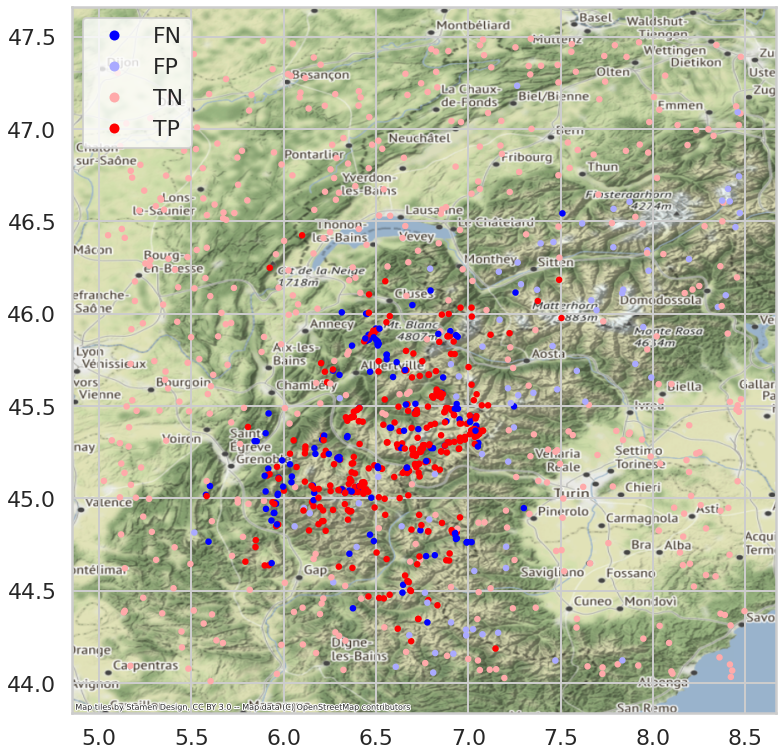

In [68]:
import contextily

ax = gdf_french_alps.plot(
    column='label', 
    categorical=True, 
    markersize=20, 
    cmap="bwr",
    figsize=(13, 13),
    legend=True
)
contextily.add_basemap(ax, crs=gdf_french_alps.crs.to_string())